<a href="https://colab.research.google.com/github/FilledEther20/Feature_Selection_Hybrid_MPA-CFHO/blob/main/Feature_Selection_Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Docs Initialized



In [ ]:
!pip install mealpy
import numpy as np
import math
import mealpy
from mealpy import FloatVar, MPA, PSO, ABC
import matplotlib.pyplot as plt
import random
# print(mealpy.__version__)
# print(np.__version__)
import logging
# Set logging level to WARNING or ERROR to suppress INFO messages
logging.getLogger('mealpy').setLevel(logging.WARNING)

#Chaotic Maps Defined

In [ ]:
def logistic_map(x):
      r=3.99
      return r * x * (1 - x)

def tent_map(x, mu=1.99):
      if x < 0.5:
          return mu * x
      else:
          return mu * (1 - x)

#Pure Fire Hawk Optimizer


In [ ]:
class FHO():
    def __init__(self, min_bounds , max_bounds, pop_size, cost_function , max_generations=200):
        self.max_generations = max_generations
        self.min_bounds      = min_bounds
        self.max_bounds      = max_bounds
        self.cost_function   = cost_function
        self.pop_size        = pop_size
        self.n_dims          = len(min_bounds) #Number of decision variables
        self.Pop             = np.random.uniform(min_bounds,max_bounds,(pop_size,self.n_dims)) #Initial Solution candidates (pop_size,n_dims)
        self.best_costs      = []
        self.costs_iter      = []
        self.minimal_p       = None
        self.path            = []
        self.global_best_fitness = []

    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)

            #Get territory of fire Hawk i
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories
    def minimize_FHO(self):
          ## Fire hawk algorithm to minimize the cost function
        n_dims = self.n_dims
        Pop = self.Pop
        pop_size = self.pop_size
        max_iterations = self.max_generations  # Control loop by iterations
        min_bounds = self.min_bounds
        max_bounds = self.max_bounds
        cost_function = self.cost_function

        # Evaluate the cost function for all candidate vectors
        cost = np.array([cost_function(Pop[i]) for i in range(pop_size)])

        # Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1

        # Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP = Pop.mean(axis=0)

        # Select fire hawks
        Fire_Hawks = Pop[:num_Hawks]

        # Select the Preys dim(pop_size - num_Hawks, n_dims)
        Preys = Pop[num_Hawks:]

        # Get territories
        territories = self.territories(Fire_Hawks, Preys)

        # Update best
        GB = cost[0]
        Best_Hawk = Pop[0]
        self.path.append(Best_Hawk)
        self.global_best_fitness.append(GB)
        self.best_costs.append(GB)
        self.costs_iter.append(cost[0])

        # Initialize a list to store the best fitness at each iteration
        best_fitness_values = [GB]

        # Iteration Counter
        iterations = 0

        ## Main Loop
        while iterations < max_iterations:
            iterations += 1
            Pop_Tot = []
            cost = []
            # Movement of Fire Hawk for all territories
            for i in territories:
                PR = territories[i].copy()
                FHl = Fire_Hawks[i].copy()
                SPl = PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a, b = np.random.uniform(0, 1, size=2)
                FHnear = Fire_Hawks[np.random.randint(num_Hawks)]
                FHl_new = FHl + (a * GB - b * FHnear)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

                # Movement of the preys following Fire Hawks movement
                for q in range(len(PR)):
                    a, b = np.random.uniform(0, 1, size=2)
                    PRq_new1 = PR[q].copy() + ((a * FHl - b * SPl))
                    PRq_new1 = np.maximum(PRq_new1, min_bounds)
                    PRq_new1 = np.minimum(PRq_new1, max_bounds)
                    Pop_Tot.append(list(PRq_new1))

                    # Movement of the preys outside of territory
                    a, b = np.random.uniform(0, 1, size=2)
                    FHAlter = Fire_Hawks[np.random.randint(num_Hawks)]
                    PRq_new2 = PR[q].copy() + ((a * FHAlter - b * SP))
                    PRq_new2 = np.maximum(PRq_new2, min_bounds)
                    PRq_new2 = np.maximum(PRq_new2, max_bounds)
                    Pop_Tot.append(list(PRq_new2))

            # Get cost
            Pop_Tot = np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))

            # Create a new population of Hawks and Preys
            order_idx = np.argsort(cost)
            cost.sort()
            Pop_Tot = np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1
            Best_Pop = Pop_Tot[0]
            SP = Pop_Tot.mean(axis=0)
            Fire_Hawks = Pop_Tot[:num_Hawks]
            Preys = Pop_Tot[num_Hawks:]

            # Get new territories
            territories = self.territories(Fire_Hawks, Preys)

            # Update Global Best cost (if relevant)
            if cost[0] < GB:
                Best_Position = Best_Pop
                GB = cost[0]
                self.minimal_p = Fire_Hawks[0]
                self.path.append(Best_Position)
            self.best_costs.append(GB)  # Append GB regardless of improvement
            self.global_best_fitness.append(GB)
            best_fitness_values.append(GB)  # Append best fitness value for plotting
            # Track the iteration calculated cost
            self.costs_iter.append(cost[0])

        # Return the list of global best fitness values for plotting
        return best_fitness_values

    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        #Plot cost evolution
        vals=np.log(self.costs_iter)
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
      return np.array(self.path).T

#Chaotic Fire Hawk Optimizer

In [ ]:
class Chaotic_FHO:
    def __init__(self, min_bounds, max_bounds, pop_size, cost_function, max_generations=200):
        self.max_generations = max_generations
        self.min_bounds = min_bounds
        self.max_bounds = max_bounds
        self.cost_function = cost_function
        self.pop_size = pop_size
        self.n_dims = len(min_bounds)  # Number of decision variables
        self.Pop = np.random.uniform(min_bounds, max_bounds, (pop_size, self.n_dims))  # Initial Solution candidates (pop_size,n_dims)
        self.best_costs = []
        self.costs_iter = []
        self.minimal_p = None
        self.path = []
        self.global_best_fitness_list = []  # New list to store global best fitness values

    def territories(self, Fire_Hawks, Preys):
        # Computing territories using the euclidean distance
        preys_left = Preys.copy()
        territories = {i: np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            # distance with respect to Fire hawk i
            D = np.linalg.norm(Fire_Hawks[i] - preys_left, axis=1)
            # Get territory of fire Hawk i
            sorted_preys_idx = np.argsort(D)
            alpha = np.random.randint(1, len(preys_left) - 1) if len(preys_left) - 1 > 1 else 1
            my_preys = sorted_preys_idx[:alpha]
            territories[i] = preys_left[my_preys]
            preys_left = preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left) == 0:
                break
        if len(preys_left) > 0:
            territories[len(Fire_Hawks) - 1] = np.array(list(territories[len(Fire_Hawks) - 1]) + list(preys_left))
        return territories

    def minimize_FHO(self):
        # Fire hawk algorithm to minimize the cost function
        Pop = self.Pop
        pop_size = self.pop_size
        max_generations = self.max_generations
        min_bounds = self.min_bounds
        max_bounds = self.max_bounds
        cost_function = self.cost_function

        # Evaluate the cost function for all candidate vectors
        cost = np.array([cost_function(Pop[i]) for i in range(pop_size)])

        # Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1

        # Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP = Pop.mean(axis=0)

        # Select fire hawks
        Fire_Hawks = Pop[:num_Hawks]

        # Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]

        # Get territories
        territories = self.territories(Fire_Hawks, Preys)

        # Update best
        GB = cost[0]
        Best_Hawk = Pop[0]
        self.path.append(Best_Hawk)

        # Counter
        FEs = pop_size
        iteration=0

        ## Main Loop
        while iteration < max_generations:
            iteration+=1
            Pop_Tot = []
            cost = []
            # Movement of Fire Hawk for all territories
            for i in territories:
                PR = territories[i].copy()
                FHl = Fire_Hawks[i].copy()
                SPl = PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a, b = np.random.uniform(0, 1, size=2)
                FHnear = Fire_Hawks[np.random.randint(len(Fire_Hawks))]

                # Update Fire Hawk's position (FHl_new) using chaotic maps
                FHl_new = FHl + (a * GB - b * FHnear)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

                # Apply chaotic map to perturb the new position
                chaos_factor = logistic_map(np.random.rand())
                FHl_new = FHl_new + 2*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

            for q in range(len(PR)):
                a, b = np.random.uniform(0, 1, size=2)
                PRq_new1 = PR[q].copy() + ((a * FHl - b * SPl))
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                # Apply chaotic map to perturb the prey's position
                chaos_factor = tent_map(np.random.rand())
                PRq_new1 = PRq_new1 + 2*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                Pop_Tot.append(list(PRq_new1))

                # Movement of the preys outside of territory
                a, b = np.random.uniform(0, 1, size=2)
                FHAlter = Fire_Hawks[np.random.randint(num_Hawks)]
                PRq_new2 = PR[q].copy() + ((a * FHAlter - b * SP))
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                # Apply chaotic map to perturb the prey's alternative movement
                chaos_factor = tent_map(np.random.rand())
                PRq_new2 = PRq_new2 + 2*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                Pop_Tot.append(list(PRq_new2))

            # Get cost
            Pop_Tot = np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs += 1

            # Create a new population of Hawks and Preys
            order_idx = np.argsort(cost)
            cost.sort()
            Pop_Tot = np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1
            Best_Pop = Pop_Tot[0]
            SP = Pop_Tot.mean(axis=0)
            Fire_Hawks = Pop_Tot[:num_Hawks]
            Preys = Pop_Tot[num_Hawks:]

            # Get new territories
            territories = self.territories(Fire_Hawks, Preys)

            # Update Global Best cost (if relevant)
            if cost[0] < GB:
                Best_Position = Best_Pop
                GB = cost[0]
                self.best_costs.append(GB)
                self.minimal_p = Fire_Hawks[0]
                self.path.append(Best_Position)
            else:
                self.best_costs.append(GB)

            # Track the iteration calculated cost
            self.costs_iter.append(cost[0])

            # Store global best fitness in the list
            self.global_best_fitness_list.append(GB)  # New line to track global best fitness

        # Return Global Best fitness list and minimal point
        return self.global_best_fitness_list

    def plot_costs(self):
        # Plot cost evolution
        vals = self.costs_iter
        n = len(vals)
        vals2 = self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n), vals, label="Iteration's calculated Cost")
        plt.plot(np.arange(n), vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        # Plot log cost evolution
        vals = np.log(self.costs_iter)
        n = len(vals)
        vals2 = self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n), vals, label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
        return np.array(self.path).T


# ChFHO-MPA Combined(Hybrid)

In [ ]:
import numpy as np

def hybrid_chFHO_MPA(min_bounds, max_bounds, pop_size, cost_function, max_generations, chFHO_ratio=0.30):
    # Initialize population and variables
    n_dims = len(min_bounds)
    population = np.random.uniform(min_bounds, max_bounds, (pop_size, n_dims))
    global_best_fitness = float('inf')  # Track the best fitness found
    global_best_solution = None

    # Determine subgroup sizes
    chFHO_pop_size = int(chFHO_ratio * pop_size)
    MPA_pop_size = pop_size - chFHO_pop_size

    # Initialize an empty list to store global best fitness values at each iteration
    global_best_fitness_list = []

    # Run the algorithm for the specified number of generations
    for generation in range(max_generations):
        # Split population into two subgroups: ChFHO and MPA
        chFHO_group = population[:chFHO_pop_size]
        MPA_group = population[chFHO_pop_size:]

        # Perform exploitation using MPA
        MPA_group = MPA_update(MPA_group, min_bounds, max_bounds, cost_function, global_best_solution)

        # Find the best individual in the current MPA group
        for individual in MPA_group:
            fitness = cost_function(individual)
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_solution = individual

        # Perform exploration using ChFHO, utilizing the best solution found by MPA
        chFHO_group = chFHO_update(chFHO_group, min_bounds, max_bounds, cost_function, global_best_solution)

        # Merge both groups back into the full population
        population = np.vstack((chFHO_group, MPA_group))

        # Evaluate fitness of the entire population
        for individual in population:
            fitness = cost_function(individual)
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_solution = individual

        # Store the current global best fitness value
        global_best_fitness_list.append(global_best_fitness)

        # Print progress (optional)
        if generation % 5 == 0:
            print(f"Generation {generation}: Best Fitness = {global_best_fitness}")

    # Return the global best solution and fitness progression over iterations
    return global_best_fitness_list


def MPA_update(population, min_bounds, max_bounds, cost_function, best_individual, adaptive_factor=0.7):
    pop_size, n_dims = population.shape
    new_population = np.zeros_like(population)

    for i in range(pop_size):
        p = np.random.rand()  # Random probability
        distance_to_best = np.linalg.norm(population[i] - best_individual) if best_individual is not None else 0
        adaptive_step_size = adaptive_factor / (1 + distance_to_best)  # Adjust step size based on distance

        if p < 0.8:
            # Lévy flight for exploration (global search)
            levy_step = levy_flight(n_dims, beta=1.5)
            new_solution = population[i] + adaptive_step_size * levy_step * (best_individual - population[i]) if best_individual is not None else levy_step
        else:
            # Enhanced Brownian motion for exploitation (local search)
            brownian_step = brownian_motion(n_dims) * adaptive_step_size  # Dynamic step size
            new_solution = population[i] + brownian_step * (population[np.random.randint(pop_size)] - population[i])

        # Apply boundary constraints
        new_solution = np.clip(new_solution, min_bounds, max_bounds)

        # Accept new solution if it's better
        if cost_function(new_solution) < cost_function(population[i]):
            new_population[i] = new_solution
        else:
            new_population[i] = population[i]  # Retain the old solution

    return new_population


def chFHO_update(population, min_bounds, max_bounds, cost_function, global_best_solution):
    pop_size, n_dims = population.shape
    new_population = np.zeros_like(population)

    for i in range(pop_size):
        # Select two random individuals for chaotic-based exploration
        r1, r2 = np.random.choice(np.arange(pop_size), size=2, replace=False)
        a, b = np.random.uniform(0, 1, size=2)  # Random weights

        # Update position using a chaotic map (e.g., tent map)
        chaotic_factor = logistic_map(np.random.rand())
        new_solution = population[i] + a * (population[r1] - population[r2])

        # Incorporate the best individual found by MPA for better exploration
        if global_best_solution is not None:
            new_solution += b * chaotic_factor * (global_best_solution - population[i])

        # Ensure bounds are respected
        new_solution = np.clip(new_solution, min_bounds, max_bounds)

        # Accept new solution if it's better
        if cost_function(new_solution) < cost_function(population[i]):
            new_population[i] = new_solution
        else:
            new_population[i] = population[i]

    return new_population


def levy_flight(n_dims, beta=1.3):
    # Lévy flight function for exploration
    sigma_u = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
               (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma_u, size=n_dims)
    v = np.random.normal(0, 1, size=n_dims)
    step = u / (np.abs(v) ** (1 / beta))
    return step


def brownian_motion(n_dims):
    # Brownian motion function for exploitation
    step = np.random.normal(0, 1, size=n_dims)
    return step


def logistic_map(x):
    # Logistic map function for chaotic behavior
    r = 4  # Growth rate
    return r * x * (1 - x)

# Benchmark Functions Defined

In [ ]:
# Sphere function objective
def sphere_function(solution):
    return np.sum(np.square(solution))

# # Rastirgin function objective
# def rastirgin_function(solution):
#   return 10*len(solution) + np.sum(np.square(solution)-10*np.cos(2*np.pi*solution))

# Griewank function objective
def griewank_function(solution):
    n = len(solution)
    sum_sq_term = np.sum(np.square(solution))
    product_term = np.prod(np.cos(solution / np.sqrt(np.arange(1, n + 1))))
    return sum_sq_term / 4000 - product_term + 1


# # #Matya's function objective
def matyas_function(x):
    x1, x2 = x[:2]
    return 0.26 * (x1**2 + x2**2) - 0.48 * x1 * x2

# Ackley function objective
def ackley_function(solution):
  n=len(solution)
  sum_sq_term=-0.2*np.sqrt(np.sum(solution**2)/n)
  cos_term=np.sum(np.cos(2*np.pi*solution))/n
  return -20*np.exp(sum_sq_term)-np.exp(cos_term)+20+np.exp(1)

# Rosenbrock function objective
def rosenbrock_function(solution):
      return np.sum(100 * (solution[1:] - solution[:-1]**2)**2 + (solution[:-1] - 1)**2)

def himmelblau_function(solution):
    x, y = solution[0], solution[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Levy function objective
def levy_function(solution):
    solution = np.asarray(solution)
    # Ensure that solution has at least two dimensions
    if len(solution) < 2:
        raise ValueError("Input vector must have at least two dimensions.")

    # Calculate w
    w = 1 + (solution - 1) / 4

    # Compute the Levy function
    term1 = np.sin(np.pi * w[0]) ** 2
    term2 = np.sum((w[:-1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[:-1] + 1) ** 2))
    term3 = (w[-1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[-1]) ** 2)

    return term1 + term2 + term3

# Define the Rastrigin objective function
def rastrigin_function(solution):
    n = len(solution)
    A = 10
    return A * n + np.sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in solution])



# Plotting Function Defined


In [ ]:
def plot_performance(fitness_values_dict, title, ylabel, filename=None):
    plt.figure(figsize=(10, 6))
    for label, values in fitness_values_dict.items():
        plt.plot(values, label=label)
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()


# Problem Dictionary Defined

In [ ]:

# Define problem dictionary for each function
problem_dicts = {
    "Griewank": {
        "obj_func": griewank_function,
        "bounds": FloatVar(lb=[-600] * 30, ub=[600] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Ackley": {
        "obj_func": ackley_function,
        "bounds": FloatVar(lb=[-10.] * 30, ub=[10] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Rosenbrock": {
        "obj_func": rosenbrock_function,
        "bounds": FloatVar(lb=[-10.,] * 30, ub=[10.,] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Levy": {
        "obj_func": levy_function,
        "bounds": FloatVar(lb=[-10] * 30, ub=[10] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },

    "Rastrigin": {
        "obj_func": rastrigin_function,
        "bounds": FloatVar(lb=[-5.12] * 30, ub=[5.12] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    }
}

# Define algorithms
def run_optimization(algorithm, problem_dict):
    optimizer = algorithm(
        epoch=550, pop_size=20
    )
    optimizer.solve(problem_dict)
    return optimizer.history.list_global_best_fit


# Results in Tabular Format


In [ ]:
from mealpy import ALO, ACOR
import numpy as np
import pandas as pd

# Initialize a dictionary to store results for each problem
results = {problem: {'MPA': [], 'PSO': [], 'FHO': [], 'CFHO': [], 'Hybrid': []} for problem in problem_dicts}

# Run optimization for each algorithm on each objective function
for func_name, problem_dict in problem_dicts.items():
    # # Skip specific functions
    # if func_name in ["Levy", "Rastrigin", "Ackley", "Rosenbrock"]:
    #     continue

    # MPA Optimization
    fitness_values_MPA = run_optimization(MPA.OriginalMPA, problem_dict)
    results[func_name]['MPA'] = fitness_values_MPA

    # PSO Optimization
    fitness_values_PSO = run_optimization(PSO.OriginalPSO, problem_dict)
    results[func_name]['PSO'] = fitness_values_PSO

    # FHO Optimization
    fitness_values_FHO = run_optimization(ACOR.OriginalACOR, problem_dict)
    results[func_name]['FHO'] = fitness_values_FHO

    # Chaotic FHO Optimization
    fitness_values_CFHO = run_optimization(ALO.DevALO, problem_dict)
    results[func_name]['CFHO'] = fitness_values_CFHO

    # Hybrid Algorithm Optimization
    fitness_values_hybrid = hybrid_chFHO_MPA(
        min_bounds=problem_dict['bounds'].lb,
        max_bounds=problem_dict['bounds'].ub,
        pop_size=50,
        cost_function=problem_dict['obj_func'],
        max_generations=550,
    )
    results[func_name]['Hybrid'] = fitness_values_hybrid

# Calculate mean and standard deviation for each algorithm on each objective function
performance_metrics = {}

for problem_name, algo_results in results.items():
    performance_metrics[problem_name] = {}
    for algo_name, fitness_list in algo_results.items():
        mean_fitness = np.mean(fitness_list)
        std_fitness = np.std(fitness_list)
        performance_metrics[problem_name][algo_name] = {
            'mean': mean_fitness,
            'std': std_fitness
        }

# Convert performance metrics to a pandas DataFrame
rows = []
columns = ["Objective Function", "MPA Mean", "MPA Std", "PSO Mean", "PSO Std", "FHO Mean", "FHO Std", "CFHO Mean", "CFHO Std", "Hybrid Mean", "Hybrid Std"]

for problem_name, algo_performance in performance_metrics.items():
    row = [problem_name]
    for algo_name in ['MPA', 'PSO', 'FHO', 'CFHO', 'Hybrid']:
        row.append(algo_performance[algo_name]['mean'])
        row.append(algo_performance[algo_name]['std'])
    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows, columns=columns)

# Print the performance table
print(df)


INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 383.082989690488, Global best: 383.082989690488, Runtime: 0.00394 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 324.4995498820569, Global best: 324.4995498820569, Runtime: 0.00438 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 281.4990072973814, Global best: 281.4990072973814, Runtime: 0.00423 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 223.8803810866377, Global best: 223.8803810866377, Runtime: 0.00455 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 209.20507530655374, Global best: 209.20507530655374, Runtime: 0.00431 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 198.4984912874288, Global best: 198.4984912874288, Runtime:

Generation 0: Best Fitness = 0.6035209989546387
Generation 5: Best Fitness = 0.6035209989546387
Generation 10: Best Fitness = 0.6035209989546387
Generation 15: Best Fitness = 0.6008767912465494
Generation 20: Best Fitness = 0.5589381579319974
Generation 25: Best Fitness = 0.5589381579319974
Generation 30: Best Fitness = 0.4339391653819029
Generation 35: Best Fitness = 0.4339391653819029
Generation 40: Best Fitness = 0.3354976023331444
Generation 45: Best Fitness = 0.29828809685277846
Generation 50: Best Fitness = 0.2953175559241259
Generation 55: Best Fitness = 0.2848296426442761
Generation 60: Best Fitness = 0.27878956756859397
Generation 65: Best Fitness = 0.2777472998899235
Generation 70: Best Fitness = 0.27736026879100795
Generation 75: Best Fitness = 0.27671173563689966
Generation 80: Best Fitness = 0.27633409895213956
Generation 85: Best Fitness = 0.2756135767759468
Generation 90: Best Fitness = 0.24208775684689166
Generation 95: Best Fitness = 0.2420818440383482
Generation 100: 

INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 11.017976266710168, Global best: 11.017976266710168, Runtime: 0.00344 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 9.316019552123558, Global best: 9.316019552123558, Runtime: 0.00409 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 9.035544597141328, Global best: 9.035544597141328, Runtime: 0.00362 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 8.884466281184864, Global best: 8.884466281184864, Runtime: 0.00370 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 8.829450774759533, Global best: 8.829450774759533, Runtime: 0.00541 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 8.82541576154416, Global best: 8.82541576154416, Runtime:

Generation 545: Best Fitness = 0.0004183301261750927


INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 26, Current best: 7.378018361358784, Global best: 7.378018361358784, Runtime: 0.00584 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 27, Current best: 7.354180038949735, Global best: 7.354180038949735, Runtime: 0.00361 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 28, Current best: 7.354180038949735, Global best: 7.354180038949735, Runtime: 0.00376 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 29, Current best: 7.354180038949735, Global best: 7.354180038949735, Runtime: 0.00353 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 30, Current best: 7.350519546474157, Global best: 7.350519546474157, Runtime: 0.00378 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 31, Current best: 7.350519546474157, Global best: 7.350519546474157, Runtime: 0.00327 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 32

Generation 0: Best Fitness = 4.171155315266155
Generation 5: Best Fitness = 4.171155315266155
Generation 10: Best Fitness = 4.154344715687472
Generation 15: Best Fitness = 3.7225546699742407
Generation 20: Best Fitness = 3.708081753614515
Generation 25: Best Fitness = 3.678128769312402
Generation 30: Best Fitness = 3.673254570540497
Generation 35: Best Fitness = 3.6717390239426426
Generation 40: Best Fitness = 3.6710042306008828
Generation 45: Best Fitness = 3.617805159070248
Generation 50: Best Fitness = 3.3453521607522885
Generation 55: Best Fitness = 3.1617371879170446
Generation 60: Best Fitness = 3.100702212306644
Generation 65: Best Fitness = 3.0976763048148794
Generation 70: Best Fitness = 3.096625591888593
Generation 75: Best Fitness = 3.0960571485441517
Generation 80: Best Fitness = 2.710219209705514
Generation 85: Best Fitness = 2.7060573390924003
Generation 90: Best Fitness = 2.704215381912111
Generation 95: Best Fitness = 2.7029427192334023
Generation 100: Best Fitness = 2.

INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 738204.9207495747, Global best: 738204.9207495747, Runtime: 0.00415 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 536979.5418252487, Global best: 536979.5418252487, Runtime: 0.00368 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 495028.32993069524, Global best: 495028.32993069524, Runtime: 0.00617 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 438182.2936784402, Global best: 438182.2936784402, Runtime: 0.00306 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 374344.2871828034, Global best: 374344.2871828034, Runtime: 0.00328 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 346701.76316480665, Global best: 346701.76316480665, Runt

Generation 540: Best Fitness = 0.06421257402217906
Generation 545: Best Fitness = 0.0641682702701627


INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 20, Current best: 98406.38667470378, Global best: 98406.38667470378, Runtime: 0.00379 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 21, Current best: 89819.31567264814, Global best: 89819.31567264814, Runtime: 0.00366 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 22, Current best: 82904.0573503802, Global best: 82904.0573503802, Runtime: 0.00368 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 23, Current best: 74925.16012264723, Global best: 74925.16012264723, Runtime: 0.00388 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 24, Current best: 68626.47275869876, Global best: 68626.47275869876, Runtime: 0.00350 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 25, Current best: 63246.74346304026, Global best: 63246.74346304026, Runtime: 0.00378 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 26, 

Generation 0: Best Fitness = 5309.988011356833
Generation 5: Best Fitness = 5309.988011356833
Generation 10: Best Fitness = 5309.988011356833
Generation 15: Best Fitness = 3398.653983263518
Generation 20: Best Fitness = 2316.9333624236565
Generation 25: Best Fitness = 1994.7139219080836
Generation 30: Best Fitness = 1910.9116511467346
Generation 35: Best Fitness = 1890.2318926625903
Generation 40: Best Fitness = 1883.3442322249095
Generation 45: Best Fitness = 1880.0722279129075
Generation 50: Best Fitness = 1878.5493808535057
Generation 55: Best Fitness = 1877.9963832954845
Generation 60: Best Fitness = 1458.2837741904636
Generation 65: Best Fitness = 1457.7053279311194
Generation 70: Best Fitness = 942.1583294124043
Generation 75: Best Fitness = 921.0561296046366
Generation 80: Best Fitness = 904.3592431407037
Generation 85: Best Fitness = 895.0703369392048
Generation 90: Best Fitness = 843.9875288675979
Generation 95: Best Fitness = 779.364198774826
Generation 100: Best Fitness = 76

INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 132.51216816524055, Global best: 132.51216816524055, Runtime: 0.00392 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 118.5751842727342, Global best: 118.5751842727342, Runtime: 0.00384 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 118.5751842727342, Global best: 118.5751842727342, Runtime: 0.00520 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 101.54185614660959, Global best: 101.54185614660959, Runtime: 0.00453 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 94.81411669242804, Global best: 94.81411669242804, Runtime: 0.00388 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 79.28125478815126, Global best: 79.28125478815126, Runt

Generation 540: Best Fitness = 30.767919532073073
Generation 545: Best Fitness = 30.767520965920976


INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 20, Current best: 34.90391656799046, Global best: 34.90391656799046, Runtime: 0.00529 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 21, Current best: 34.90391656799046, Global best: 34.90391656799046, Runtime: 0.00534 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 22, Current best: 34.90391656799046, Global best: 34.90391656799046, Runtime: 0.00533 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 23, Current best: 34.90391656799046, Global best: 34.90391656799046, Runtime: 0.00652 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 24, Current best: 34.90391656799046, Global best: 34.90391656799046, Runtime: 0.00609 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 25, Current best: 33.60962219899508, Global best: 33.60962219899508, Runtime: 0.00750 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 26

Generation 0: Best Fitness = 8.76398633901192
Generation 5: Best Fitness = 8.602420809649002
Generation 10: Best Fitness = 8.181017821582815
Generation 15: Best Fitness = 6.902934887562114
Generation 20: Best Fitness = 6.0314135600356895
Generation 25: Best Fitness = 5.910725492961514
Generation 30: Best Fitness = 5.862860724977098
Generation 35: Best Fitness = 4.874707204847989
Generation 40: Best Fitness = 4.735105072106471
Generation 45: Best Fitness = 4.735105072106471
Generation 50: Best Fitness = 4.591687104500841
Generation 55: Best Fitness = 2.7438191790388724
Generation 60: Best Fitness = 2.70648840361971
Generation 65: Best Fitness = 2.640256653491791
Generation 70: Best Fitness = 2.632373018209376
Generation 75: Best Fitness = 2.630637742788265
Generation 80: Best Fitness = 2.6284180919599103
Generation 85: Best Fitness = 2.4297582597198963
Generation 90: Best Fitness = 2.426622408773054
Generation 95: Best Fitness = 2.401027200010596
Generation 100: Best Fitness = 2.1419768

INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 407.78540878959296, Global best: 407.78540878959296, Runtime: 0.00464 seconds


Generation 525: Best Fitness = 0.15172003682322832
Generation 530: Best Fitness = 0.1512010975404894
Generation 535: Best Fitness = 0.13678470206101936
Generation 540: Best Fitness = 0.12176020768316187
Generation 545: Best Fitness = 0.12024186388160782


INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 407.78540878959296, Global best: 407.78540878959296, Runtime: 0.00601 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 372.541669151036, Global best: 372.541669151036, Runtime: 0.00489 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 319.1453912090726, Global best: 319.1453912090726, Runtime: 0.00517 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 319.1453912090726, Global best: 319.1453912090726, Runtime: 0.00474 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 319.1453912090726, Global best: 319.1453912090726, Runtime: 0.00484 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 7, Current best: 319.1453912090726, Global best: 319.1453912090726, Runtime: 0.00470 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 8, Curre

Generation 0: Best Fitness = 299.2637329633976
Generation 5: Best Fitness = 253.03115455869872
Generation 10: Best Fitness = 220.00469931409904
Generation 15: Best Fitness = 215.7817623801867
Generation 20: Best Fitness = 202.20799184254176
Generation 25: Best Fitness = 185.93819742318118
Generation 30: Best Fitness = 174.78090979211555
Generation 35: Best Fitness = 169.97537143688896
Generation 40: Best Fitness = 166.42530557286105
Generation 45: Best Fitness = 166.42530557286105
Generation 50: Best Fitness = 166.42530557286105
Generation 55: Best Fitness = 166.42530557286105
Generation 60: Best Fitness = 166.42530557286105
Generation 65: Best Fitness = 166.42530557286105
Generation 70: Best Fitness = 166.42530557286105
Generation 75: Best Fitness = 166.42530557286105
Generation 80: Best Fitness = 166.42530557286105
Generation 85: Best Fitness = 166.42530557286105
Generation 90: Best Fitness = 158.6034498409909
Generation 95: Best Fitness = 127.84788575243425
Generation 100: Best Fitn

# Testing & Plotting Graph


INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 2163777.0750342156, Global best: 2163777.0750342156, Runtime: 0.01498 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 1234817.7028583416, Global best: 1234817.7028583416, Runtime: 0.01122 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 807496.9726045054, Global best: 807496.9726045054, Runtime: 0.01754 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 738195.7190347428, Global best: 738195.7190347428, Runtime: 0.01873 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 735668.226527115, Global best: 735668.226527115, Runtime: 0.01744 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 715334.0358807881, Global best: 715334.0358807881, Runtim

Generation 0: Best Fitness = 4197.686669061652
Generation 5: Best Fitness = 4197.686669061652
Generation 10: Best Fitness = 4197.686669061652
Generation 15: Best Fitness = 3277.082857842142
Generation 20: Best Fitness = 1884.435262500527
Generation 25: Best Fitness = 1737.9216552466096
Generation 30: Best Fitness = 1689.2117958770882
Generation 35: Best Fitness = 1669.7685384532413
Generation 40: Best Fitness = 1425.00034768641
Generation 45: Best Fitness = 1416.3137914268393
Generation 50: Best Fitness = 1412.2737961401463
Generation 55: Best Fitness = 702.9957021876509
Generation 60: Best Fitness = 696.4680785203416
Generation 65: Best Fitness = 690.0554885160245
Generation 70: Best Fitness = 689.8901462554394
Generation 75: Best Fitness = 350.52915946110363
Generation 80: Best Fitness = 337.67065814916367
Generation 85: Best Fitness = 335.321876007687
Generation 90: Best Fitness = 327.6869261229927
Generation 95: Best Fitness = 327.23536359152905
Generation 100: Best Fitness = 326.8

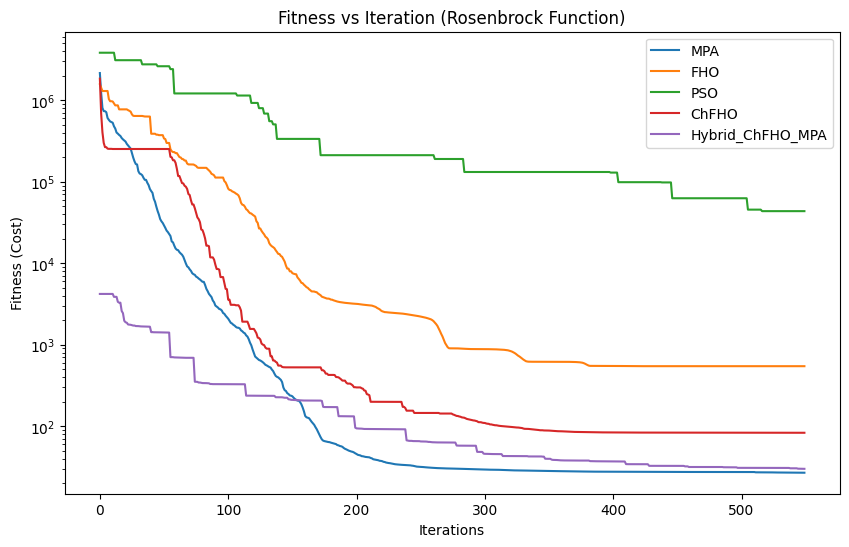

In [ ]:
from mealpy import ALO,ACOR
# Define the plotting for each function
for func_name, problem_dict in problem_dicts.items():
    if func_name=="Ackley" or func_name=="Griewank" or func_name=="Rastrigin" or func_name=="Levy":
      continue

    # # # FHO Optimization
    # min_bounds=problem_dict['bounds'].lb
    # max_bounds=problem_dict['bounds'].ub
    # opti_FHO=FHO(min_bounds,max_bounds,50,problem_dict['obj_func'],550)
    # fitness_values_FHO = opti_FHO.minimize_FHO()
    # print(fitness_values_FHO)



    # # MPA Optimization
    fitness_values_MPA = run_optimization(MPA.OriginalMPA, problem_dict)

    # #FHO optimization
    fitness_values_PSO = run_optimization(PSO.OriginalPSO, problem_dict)

    # # # # PSO Optimization
    # fitness_values_FHO = run_optimization(ACOR.OriginalACOR, problem_dict)



    # # Chaotic_FHO Optimization
    # minD = problem_dict['bounds'].lb
    # maxD = problem_dict['bounds'].ub
    # opti = Chaotic_FHO(minD, maxD, pop_size=30, cost_function=problem_dict['obj_func'], max_generations=200)
    # fitness_values_CFHO=run_optimization(ALO.DevALO,problem_dict)



    # Hybrid Algorithm Optimization
    fitness_values_hybrid = hybrid_chFHO_MPA(
        min_bounds=problem_dict['bounds'].lb,
        max_bounds=problem_dict['bounds'].ub,
        pop_size=50,
        cost_function=problem_dict['obj_func'],
        max_generations=550,
        # chFHO_iter=200  # Number of iterations for chFHO
    )
    # print(fitness_values_hybrid)




    # Plot results
    plot_performance({
        "MPA": fitness_values_MPA,
        "FHO": fitness_values_PSO,
        # "PSO": fitness_values_FHO,
        # "ChFHO":fitness_values_CFHO,
        "Hybrid_ChFHO_MPA": fitness_values_hybrid
    }, f"Fitness vs Iteration ({func_name} Function)", "Fitness (Cost)", f"{func_name.lower()}_performance.png")